In [1]:
import random
import gensim
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.decomposition
import sklearn.feature_extraction
import ipywidgets as widgets
import seaborn as sns
from wordcloud import WordCloud
from IPython.display import display
from collections import defaultdict


In [2]:
year='2018'
papers=pd.read_csv(f'../../Kafka/output_csv/{year}.csv')

In [3]:
print(papers.shape)
papers['Title'] = papers['Title'].fillna('Untitled').str.strip()

(3993, 8)


In [4]:
def prepare_fig(w=1, h=None):
    if h is None: h = w
    figsize = (6 * w, 3 * h)
    sns.set(rc={'figure.figsize': figsize})
    fig = plt.figure(figsize=figsize)
    plt.clf()
    return fig

def top_k(mapping, k=10):
    return sorted(mapping.keys(), key=lambda x: mapping[x])[::-1][:k]

pd.set_option('display.max_rows', 250)

In [5]:
papers.head()

,Title,Abstract,Author,Aggregation_Type,Publisher,Publication_Date,Institutions,Keywords
0,Public health and international epidemiology f...,NaN,Pongpirul K.; Lungren M.P.,Book,Springer International Publishing,2018-12-31,Chulalongkorn University; Johns Hopkins Bloomb...,NaN
1,Flexible Printed Active Antenna for Digital Te...,"© 2018 The Institute of Electronics, Informati...",Pratumsiri T.; Janpugdee P.,Conference Proceeding,Institute of Electrical and Electronics Engine...,2018-12-31,Chulalongkorn University,NaN
2,Parametric study of hydrogen production via so...,© 2018 Elsevier LtdComputational fluid dynamic...,Phuakpunk K.; Chalermsinsuwan B.; Putivisutisa...,Journal,Elsevier Ltd,2018-12-31,Chulalongkorn University; Chulalongkorn Univer...,Circulating fluidized bed; Computational fluid...
3,Superhydrophobic coating from fluoroalkylsilan...,© 2018 Elsevier B.V. A superhydrophobic/supero...,Saengkaew J.; Le D.; Samart C.; Sawada H.; Nis...,Journal,Elsevier B.V.,2018-12-31,Thammasat University; Hirosaki University; Nat...,Encapsulation; Fluoroalkylsilane; Natural rubb...
4,Electrochemical impedance-based DNA sensor usi...,© 2018 Elsevier B.V. A label-free electrochemi...,Teengam P.; Siangproh W.; Tuantranont A.; Vila...,Journal,Elsevier B.V.,2018-12-31,Chulalongkorn University; Srinakharinwirot Uni...,acpcPNA; Electrochemical impedance spectroscop...


In [6]:
papers['Abstract'][4]

'© 2018 Elsevier B.V. A label-free electrochemical DNA sensor based on pyrrolidinyl peptide nucleic acid (acpcPNA)-immobilized on a paper-based analytical device (PAD) was developed. Unlike previous PNA-based electrochemical PAD (ePAD) sensors where the capture element was placed directly on the electrode, acpcPNA was covalently immobilized onto partially oxidized cellulose paper allowing regeneration by simple PAD replacement. As an example application, a sensor probe was designed for Mycobacterium tuberculosis (MTB) detection. The ePAD DNA sensor was used to determine a synthetic 15-base oligonucleotide of MTB by measuring the fractional change in the charge transfer resistance (R ct ) obtained from electrochemical impedance spectroscopy (EIS). The R ct of [Fe(CN) 6 ] 3-/4- before and after hybridization with the target DNA could be clearly distinguished. Cyclic voltammetry (CV) was used to verify the EIS results, and showed an increase in peak potential splitting in a similar stepwi

In [7]:
print(len(papers))

3993


In [8]:
texts = []
for i in range(len(papers)):
    title = str(papers['Title'][i]) if not pd.isna(papers['Title'][i]) else ''
    abstract = str(papers['Abstract'][i]) if not pd.isna(papers['Abstract'][i]) else ''
    text = title + ' ' + abstract
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9]', ' ', text) # Replace punctation by spaces
    texts.append([w for w in text.split(' ') if w]) # Split on spaces, remove empty items

print(texts[1])

['flexible', 'printed', 'active', 'antenna', 'for', 'digital', 'television', 'reception', '2018', 'the', 'institute', 'of', 'electronics', 'information', 'and', 'communication', 'engineers', 'ieice', 'this', 'paper', 'presents', 'the', 'development', 'of', 'a', 'flexible', 'printed', 'active', 'antenna', 'for', 'the', 'digital', 'television', 'dtv', 'reception', 'in', 'areas', 'having', 'poor', 'signal', 'or', 'in', 'high', 'rise', 'buildings', 'the', 'antenna', 'structure', 'is', 'composed', 'of', 'a', 'meander', 'line', 'printed', 'on', 'a', 'polyimide', 'film', 'as', 'a', 'radiating', 'element', 'it', 'has', 'a', 'thickness', 'of', '0', '3', 'mm', 'highly', 'flexible', 'and', 'very', 'lightweight', 'the', 'design', 'and', 'analysis', 'of', 'the', 'radiating', 'element', 'are', 'based', 'on', 'a', 'full', 'wave', 'method', 'implemented', 'by', 'a', 'commercial', 'electromagnetic', 'simulation', 'software', 'the', 'amplifier', 'circuit', 'consisting', 'of', 'a', 'surface', 'mount', 't

In [9]:
import logging
# Load stopwords, bigrams, and stem rules
try:
    stopwords = set()
    with open('stopwords.txt', 'r') as f:
        stopwords = [w.strip() for w in f if w.strip()]
                
    print('loaded {} stopwords'.format(len(stopwords)))
except Exception as e:
    logging.error('failed to load stopwords.txt: {}'.format(e))

try:
    bigrams = dict()
    with open('bigrams.txt', 'r') as f:
        for line in f:
            if line.strip():
                a, b, c = line.split()
                bigrams[a, b] = c
        
    print('loaded {} bigrams'.format(len(bigrams)))
except Exception as e:
    logging.error('failed to load bigrams.txt: {}'.format(e))
    
try:
    stem_rules = dict()
    with open('stemming.txt', 'r') as f:
        for line in f:
            if line.strip():
                a, b = line.strip().split()
                stem_rules[a] = b
        
    print('loaded {} stem rules'.format(len(stem_rules)))
except Exception as e:
    logging.error('failed to load stemming.txt: {}'.format(e))

loaded 174 stopwords
loaded 97 bigrams
loaded 3 stem rules


In [10]:
# Print common words
one_count = defaultdict(int)

for text in texts:
    for a in text:
        one_count[a] += 1
     
print('Top words')
display(pd.DataFrame(
    [(w, one_count[w], 'Yes' * (w in stopwords)) for w in top_k(one_count, 250)],
    columns=['word', 'count', 'in stopwords.txt?']))



Top words


,word,count,in stopwords.txt?
0,the,49276,Yes
1,of,36189,Yes
2,and,33852,Yes
3,in,20777,Yes
4,to,17459,Yes
5,a,13758,
6,for,9297,Yes
7,with,8243,Yes
8,is,6708,Yes
9,on,5731,Yes


In [11]:
# Print common bigrams
two_count = defaultdict(int)

for text in texts:
    for a, b in zip(text, text[1:]):
        if a not in stopwords and b not in stopwords:
            two_count[a, b] += 1
            
print('Top bigrams')
display(pd.DataFrame(
    [(w, two_count[w], 'Yes' * (w in bigrams)) for w in top_k(two_count, 250)],
    columns=['bigram', 'count', 'in bigrams.txt?']))

Top bigrams


,bigram,count,in bigrams.txt?
0,"(p, 0)",719,
1,"(rights, reserved)",446,
2,"(95, ci)",340,
3,"(author, s)",291,
4,"(2018, elsevier)",267,
5,"(0, 05)",207,
6,"(0, 001)",206,
7,"(b, v)",193,
8,"(proton, proton)",192,
9,"(elsevier, b)",166,


In [12]:
# Merge bigrams
for text in texts:
    i = 0
    
    while i < len(text) - 1:
        a, b = text[i], text[i + 1]
        
        if (a, b) in bigrams:
            text[i:i+2] = [bigrams[a,b]]
        else:
            i += 1

In [13]:
# Filter tokens
def filter_texts(texts, f):
    return [[token for token in text if f(token)] for text in texts] 

texts = filter_texts(texts, lambda t: t not in stopwords) # Filter stopwords
texts = filter_texts(texts, lambda t: len(t) > 1) # Remove single char words 
texts = filter_texts(texts, lambda t: not re.match('^[0-9]+$', t)) # Remove numbers

In [14]:
# Stemming
stemmer = gensim.parsing.PorterStemmer()
word_count = defaultdict(int)
stemming = dict()
unstemming = dict()


# Stem each word and count "word, stem" pairs
for text in texts:
    for token in text:
        word_count[token] += 1
    
# Sorted stems by frequency, the value for unstemming[stem] is overwritten 
# and should be the one with the highest count.
for token in sorted(word_count.keys(), key=word_count.get):
    stem = stemmer.stem(token)
    stemming[token] = stem
    unstemming[stem] = token

# Overwrite with user defined rules
for a, b in stem_rules.items():
    stemming[a] = b
    unstemming[b] = b

# Stem words
stemmed_texts = [[unstemming[stemming[token]] for token in text] for text in texts]

logging.info('stemming reduced {} to {} tokens'.format(len(stemming), len(unstemming)))
pd.DataFrame(
    [(
        token, 
        stemming[token], 
        unstemming[stemming[token]], 
        word_count[token]
    ) for token in top_k(word_count, k=250)],
    columns=['Original', 'Stem', 'Unstem', 'Count'])

,Original,Stem,Unstem,Count
0,research,research,research,2743
1,innovation,innov,innovation,2113
2,engineering,engin,engineering,1663
3,development,develop,development,1561
4,data,data,data,1535
5,analysis,analysi,analysis,1523
6,patients,patient,patients,1469
7,model,model,model,1425
8,technology,technolog,technology,1358
9,group,group,group,913


In [15]:
# Remove papers with less than 25 words after preprocessing
n = len(papers)
indices = [i for i in range(len(papers)) if len(stemmed_texts[i]) > 25]
papers = papers.iloc[indices]
final_texts = [stemmed_texts[i] for i in indices]

print('papers: {} (removed {})'.format(len(papers), n - len(papers)))

papers: 3875 (removed 118)


In [16]:
dic = gensim.corpora.Dictionary(final_texts)
dic.filter_extremes(0, 0.5) # Remove 
dic.filter_extremes(5, 1)   # 
corpus = [dic.doc2bow(text) for text in final_texts]

print('papers: {}'.format(len(corpus)))
print('dictionary size: {}'.format(len(dic)))

papers: 3875
dictionary size: 5743


In [17]:
# Create frequency matrix
n, m = len(corpus), len(dic)
matrix = np.zeros((n, m))

for i, row in enumerate(corpus):
    for j, freq in row:
        matrix[i,j] = freq

In [18]:
num_topics = 12
seed = 7

tfidf_model = sklearn.feature_extraction.text.TfidfTransformer()
tfidf_matrix = tfidf_model.fit_transform(matrix).toarray()
nmf_model = sklearn.decomposition.NMF(
    n_components=num_topics,
    random_state=seed,
    tol=1e-9,
    max_iter=500,
    verbose=True)

# Train model
doc2topic = nmf_model.fit_transform(tfidf_matrix)
topic2token = nmf_model.components_

topic_norm = np.sum(topic2token, axis=1)
topic2token /= topic_norm[:,np.newaxis]
doc2topic *= topic_norm[np.newaxis,:]

doc_norm = np.sum(doc2topic, axis=1)
doc2topic /= doc_norm[:,np.newaxis]

violation: 1.0
violation: 0.21135187962988586
violation: 0.13328712149279717
violation: 0.09554090786731596
violation: 0.07362929865898143
violation: 0.056541663170553785
violation: 0.04244542919461991
violation: 0.032728077495785546
violation: 0.02581150788898576
violation: 0.02110448929532251
violation: 0.017738376010555206
violation: 0.015237425849354485
violation: 0.013321165044515476
violation: 0.011810997617982922
violation: 0.01062325015500154
violation: 0.00966391194848161
violation: 0.008867808707666408
violation: 0.008200157912355642
violation: 0.007647317704796612
violation: 0.007192036124624449
violation: 0.0068095927620602965
violation: 0.006476071810736594
violation: 0.006186639638667212
violation: 0.005950653745866771
violation: 0.0057452284601483454
violation: 0.005552493582870938
violation: 0.005386453885820385
violation: 0.005227900270749051
violation: 0.005078016466627408
violation: 0.004928876623897926
violation: 0.004764540756320356
violation: 0.00460935632033909
v

/Users/pookansmacbookpro/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


In [19]:
rows = []
labels = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
for label, vec in zip(labels, topic2token):
    rows.append([label] + ['{} ({:.2})'.format(dic[i], vec[i]) for i in np.argsort(vec)[::-1][:10]])

# Each row is a topic, columns are words ordered by weight 
pd.DataFrame(rows)

,0,1,2,3,4,5,6,7,8,9,10
0,A,engineering (0.036),project (0.018),research (0.016),development (0.012),university (0.0093),program (0.0079),construction (0.0071),science (0.0066),training (0.005),scientific (0.005)
1,B,proton (0.032),decay (0.023),mass (0.023),tev (0.021),boson (0.021),quark (0.021),collisions (0.021),search (0.018),jet (0.016),pair (0.014)
2,C,catalyst (0.02),carbon (0.012),production (0.012),co2 (0.011),oil (0.0098),acid (0.0094),gas (0.008),hydrogen (0.0078),temperature (0.0077),activity (0.0074)
3,D,patients (0.028),group (0.0094),treatment (0.0076),disease (0.0065),clinical (0.0058),outcomes (0.0056),risk (0.0056),ci (0.0053),control (0.0047),associated (0.0046)
4,E,cells (0.034),cancer (0.014),protein (0.012),activity (0.011),expression (0.011),compounds (0.007),induced (0.0068),lung (0.0053),cytotoxicity (0.0053),against (0.0053)
5,F,learning (0.059),teaching (0.02),teachers (0.017),course (0.015),educational (0.011),student (0.011),skills (0.011),school (0.009),learners (0.0086),activity (0.0082)
6,G,model (0.017),data (0.0077),algorithm (0.0066),network (0.0061),simulation (0.006),business (0.005),computer (0.0048),technique (0.0047),performance (0.0044),software (0.004)
7,H,species (0.018),isolated (0.015),gene (0.012),strain (0.011),sequence (0.0095),dna (0.0086),sp (0.0078),genus (0.0064),genome (0.0062),infection (0.0062)
8,I,innovation (0.047),service (0.014),production (0.013),business (0.012),firms (0.012),companies (0.01),management (0.01),industry (0.0096),research (0.009),manufacturing (0.0085)
9,J,technology (0.066),industry (0.014),development (0.012),research (0.012),innovation (0.009),science (0.0084),energy (0.0071),management (0.0057),patents (0.0056),digital (0.0055)


In [20]:
rows = []
labels = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

for label, vec in zip(labels, topic2token):
    # สำหรับแต่ละหัวข้อ (topic) นำคำและค่า (word and weight) มาจัดเรียง
    row = [label]
    for i in np.argsort(vec)[::-1][:3]:  # แสดงแค่คำที่มีน้ำหนักสูงสุด 3 คำ
        word = dic[i]
        value = vec[i]
        row.append(f"{word} ({value:.4f})")  # จัดรูปแบบให้คำกับค่ามีรูปแบบเช่น 'คำ (ค่าความสำคัญ)'
    rows.append(row)

# เปลี่ยน rows ให้เป็น DataFrame

topic_df = pd.DataFrame(rows, columns=['Topic'] + ['Top 1', 'Top 2', 'Top 3'])
#topic_df.to_csv(f'../DA/VisualizeData/{year}_Topic.csv'  )


# แสดง Top 20 คำจากแต่ละหัวข้อ (โดยไม่ต้องแสดงค่าน้ำหนัก)
rows = []
labels = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

for label, vec in zip(labels, topic2token):
    # สำหรับแต่ละหัวข้อ (topic), เอาคำที่มีน้ำหนักสูงสุด 20 คำ
    top_words = [dic[i] for i in np.argsort(vec)[::-1][:20]]  # เลือกคำ 20 คำที่มีน้ำหนักสูงสุด
    rows.append([label] + top_words)

# เปลี่ยน rows ให้เป็น DataFrame
topic_df = pd.DataFrame(rows, columns=['Topic'] + [f'Top {i+1}' for i in range(20)])

# แสดงผล DataFrame
print(topic_df)
topic_df.to_csv(f'../DA/VisualizeData/{year}_Topic.csv'  )

   Topic        Top 1     Top 2        Top 3        Top 4        Top 5  \
0      A  engineering   project     research  development   university   
1      B       proton     decay         mass          tev        boson   
2      C     catalyst    carbon   production          co2          oil   
3      D     patients     group    treatment      disease     clinical   
4      E        cells    cancer      protein     activity   expression   
5      F     learning  teaching     teachers       course  educational   
6      G        model      data    algorithm      network   simulation   
7      H      species  isolated         gene       strain     sequence   
8      I   innovation   service   production     business        firms   
9      J   technology  industry  development     research   innovation   
10     K       health   factors         care          age   associated   
11     L   properties     films    materials    composite      surface   

        Top 6         Top 7       Top

Topic 0 (A)
Topic 1 (B)
Topic 2 (C)
Topic 3 (D)
Topic 4 (E)
Topic 5 (F)
Topic 6 (G)
Topic 7 (H)
Topic 8 (I)
Topic 9 (J)
Topic 10 (K)
Topic 11 (L)


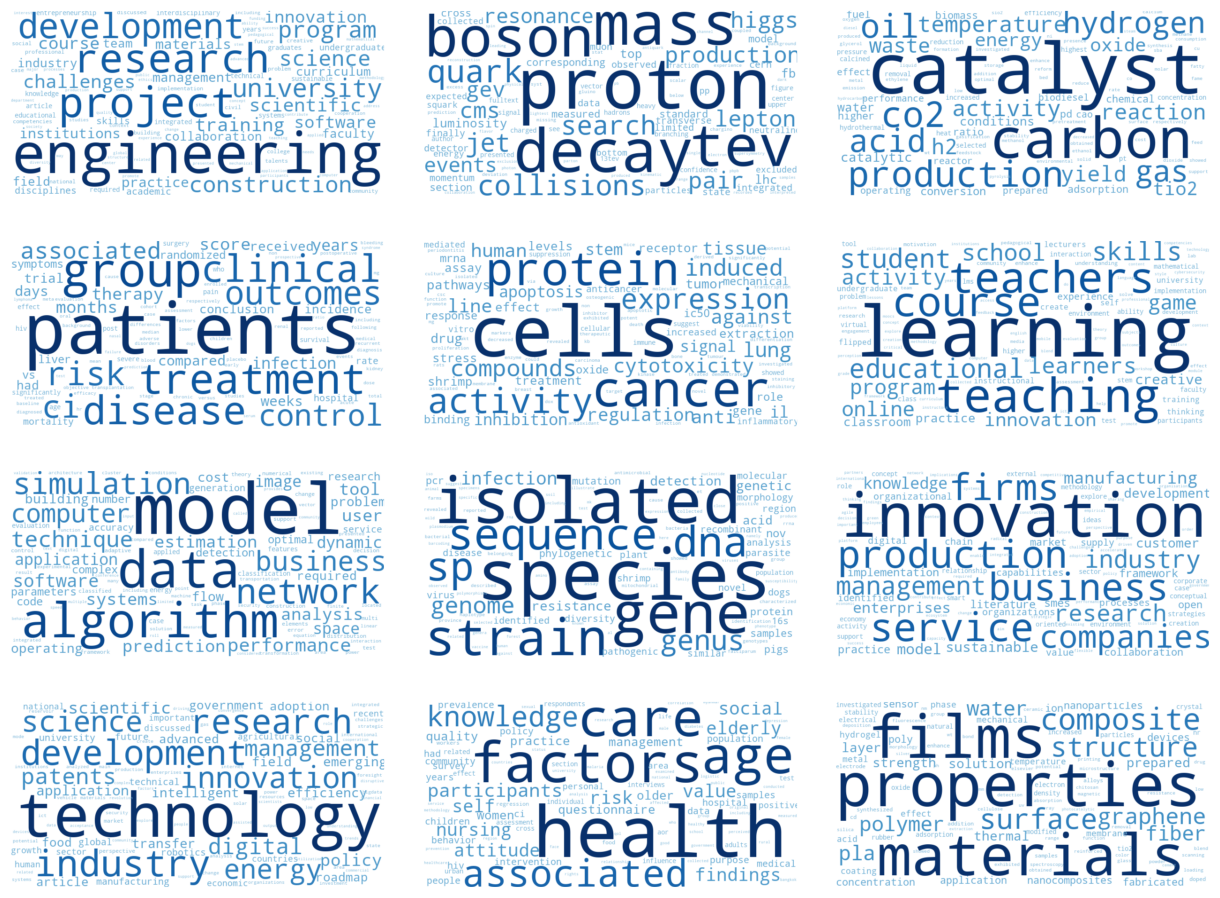

In [22]:
prepare_fig(2, 3)
for index in range(num_topics):
    mapping = dict()
    for i in np.argsort(topic2token[index])[::-1][:100]:
        if topic2token[index,i] > 0:
            mapping[dic[i]] = topic2token[index,i]
    
    def get_color(word, **kwargs):
        weight = kwargs['font_size'] / 60.0 * 0.6 + 0.4
        r, g, b = plt.get_cmap('Blues')(weight)[:3]
        return 'rgb(%s, %s, %s)' % (int(r * 255), int(g * 255), int(b * 255))
    
    wc = WordCloud(
        prefer_horizontal=True,
        max_font_size=75,
        #width=395,
        #height=250,
        scale=2,
        background_color='white', 
        color_func=get_color, 
        relative_scaling=0.5)
    wc.fit_words(mapping)
    
    print('Topic {} ({})'.format(index, labels[index]))
    plt.subplot(4, 3, index + 1)
    plt.imshow(wc.to_array(), interpolation='bilinear')
    plt.xticks([])
    plt.yticks([])
    
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.1, hspace=0.1)
plt.show()

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 3875 samples in 0.000s...
[t-SNE] Computed neighbors for 3875 samples in 0.415s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3875
[t-SNE] Computed conditional probabilities for sample 2000 / 3875
[t-SNE] Computed conditional probabilities for sample 3000 / 3875
[t-SNE] Computed conditional probabilities for sample 3875 / 3875
[t-SNE] Mean sigma: 0.008525
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.813721
[t-SNE] KL divergence after 1000 iterations: 1.384482


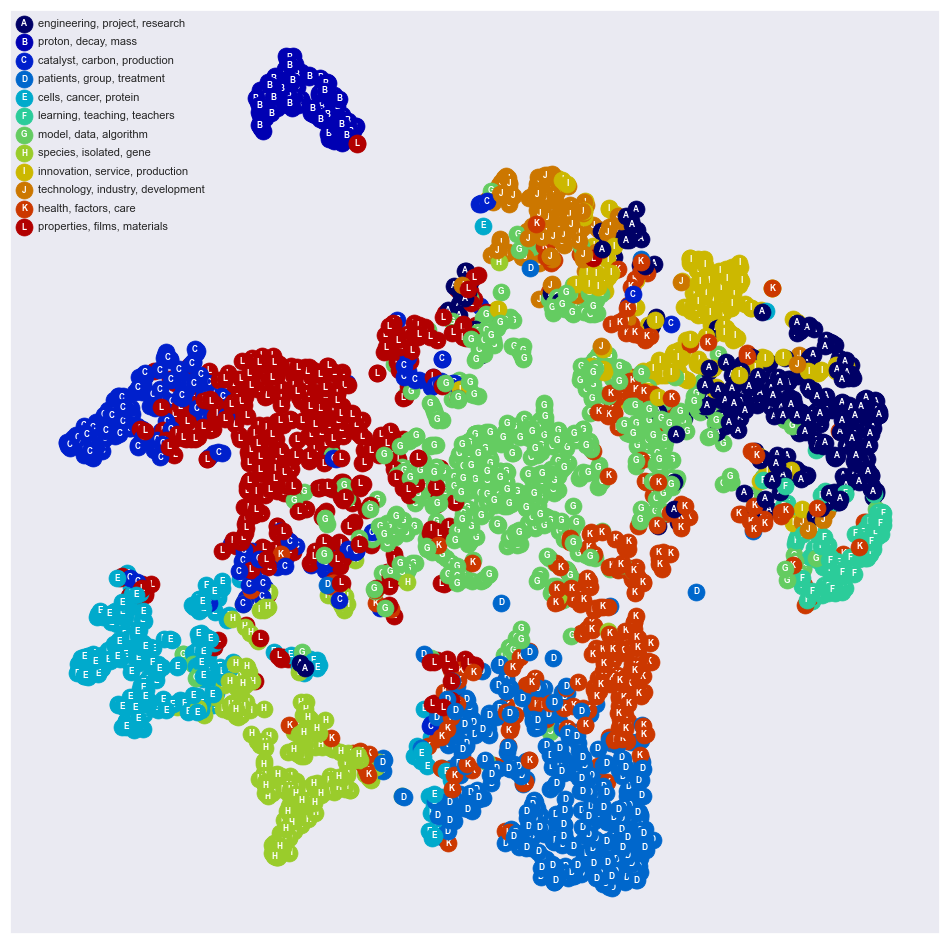

In [23]:
import sklearn.manifold
import sklearn.metrics.pairwise
from sklearn.decomposition import TruncatedSVD
vis_seed = 6
vis_angle = 135

def draw_dot(p, t, zorder=0):
    color = plt.get_cmap('jet')(float(t) / num_topics)
    color = 0.8 * np.array(color)[:3]
    
    plt.scatter(
        p[0], 
        p[1],
        s=150,
        c=[color],
        marker='o',
        linewidth=0.5,
        zorder=zorder)
    
    plt.text(
        p[0], 
        p[1],
        labels[t],
        fontsize=6,
        color='1',
        va='center',
        ha='center',
        fontweight='bold',
        zorder=zorder + 1)

# Lower dimensionality of original frequency matrix to improve cosine distances for visualization
reduced_matrix = TruncatedSVD(
    n_components=10, 
    random_state=seed
).fit_transform(tfidf_matrix)

# Learn model
model = sklearn.manifold.TSNE(
    verbose=True,
    metric='cosine',
    random_state=vis_seed,
    perplexity=20)
pos = model.fit_transform(reduced_matrix)

# Rotate visualization
theta = np.deg2rad(vis_angle + 60)
R = np.array([[np.cos(theta), np.sin(theta)], 
              [-np.sin(theta), np.cos(theta)]])
pos = np.dot(pos, R)

# Resize so xy-position is between 0.05 and 0.95
pos -= (np.amin(pos, axis=0) + np.amax(pos, axis=0)) / 2
pos /= np.amax(np.abs(pos))
pos = (pos * 0.5) + 0.5
pos = (pos * 0.9) + 0.05

prepare_fig(2, 4)
plt.xticks([])
plt.yticks([])
plt.xlim(0, 1)
plt.ylim(0, 1)
zorder = 0

# Draw dots
for i in np.random.permutation(len(doc2topic)):
    topic_id = np.argmax(doc2topic[i])
    draw_dot(pos[i], topic_id, zorder)
    zorder += 2

# Draw legend
for i in range(num_topics):    
    y = 0.985 - i * 0.02
    label = ', '.join(dic[w] for w in np.argsort(topic2token[i])[::-1][:3])

    draw_dot([0.015, y], i)
    plt.text(0.03, y, label, ha='left', va='center', fontsize=8, zorder=zorder)
    zorder += 1

plt.show()

# แต่ละจุด ในกราฟสื่อถึงเอกสาร (หรือคำ) ที่มีการแปลงข้อมูลจากเวกเตอร์หรือการประมวลผลโมเดล Topic Modeling
# ตำแหน่งของจุด บ่งบอกถึงความคล้ายคลึงกันหรือความแตกต่างระหว่างเอกสารเหล่านั้น
# สีและขนาด ช่วยให้มองเห็นการแยกหัวข้อและความสำคัญของเอกสาร
# การกระจายตัว จะช่วยให้เห็นกลุ่มของเอกสารที่มีความคล้ายคลึงกันในหัวข้อเดียวกัน

In [26]:
def on_select(i):
    i=i-1
    p = papers.iloc[i]
    print(p['Title'])
    
    prepare_fig(1, 2)
    plt.xticks([])
    plt.yticks([])
    plt.scatter(pos.T[0], pos.T[1], c='.5')
    plt.scatter(pos[i,0], pos[i,1], c='0', marker='x')
    plt.show()

    top_words = np.argsort(topic2token, axis=1)[:,::-1]
    ticks = ['{} ({})'.format(l, ', '.join(dic[v] for v in w[:3])) for l, w in zip(labels, top_words)]
    
    fig = prepare_fig(1, 2)
    plt.barh(range(num_topics), doc2topic[i])
    plt.xlim(0, 1)
    plt.ylim(num_topics, -1)
    plt.yticks(range(num_topics), ticks)
    plt.show()
    
    print(p['Abstract'])

options = sorted([((p['Title'] or '').strip()[:50], i) for i, p in papers.iterrows()]) # Show first 50 characters of title
widget = widgets.interactive(on_select, i=options)
widget.children[-1].layout.height = '2000px'
display(widget)

interactive(children=(Dropdown(description='i', options=(("'Extending the boundaries: Bismuth-based pigments "…

In [27]:
# Find the topic with the highest score for each document
papers['topic'] = np.argmax(doc2topic, axis=1)

# Optionally, you can map the topic index to the corresponding topic label if available
papers['topic_label'] = [labels[topic_id] for topic_id in papers['topic']]

# Check the updated DataFrame
papers[['Title', 'topic', 'topic_label']].head()


,Title,topic,topic_label
1,Flexible Printed Active Antenna for Digital Te...,11,L
2,Parametric study of hydrogen production via so...,2,C
3,Superhydrophobic coating from fluoroalkylsilan...,11,L
4,Electrochemical impedance-based DNA sensor usi...,11,L
5,Evaluation of outsourcing transportation contr...,6,G


In [28]:
print(doc2topic[4])  # For a specific document `i`, check topic scores

[0.01137714 0.         0.0380307  0.         0.02441604 0.
 0.61468597 0.01851296 0.04077709 0.08520135 0.16699875 0.        ]


In [ ]:
# สมมติว่าคุณมีคอลัมน์ 'Year' ใน DataFrame ที่ระบุปี
papers['Year'] = year  # ตัวอย่าง: เพิ่มปี 2018 ให้ทุกแถว (ปรับตามไฟล์จริง)

# สร้าง DataFrame ใหม่สำหรับหัวข้อและคะแนนในแต่ละปี
topic_summary = (
    papers.groupby(['Year', 'topic_label'])
    .agg(count=('topic_label', 'size'))
    .reset_index()
)

# เปลี่ยนชื่อคอลัมน์ให้เหมาะสม
topic_summary.rename(columns={'count': 'value_count'}, inplace=True)

# # บันทึกเป็นไฟล์ใหม่

topic_summary.to_csv(f'../DA/VisualizeData/{year}_Topic_count.csv', index=False)

# ตรวจสอบผลลัพธ์
print(topic_summary)

    Year topic_label  value_count
0   2018           A          363
1   2018           B          144
2   2018           C          425
3   2018           D          724
4   2018           E          278
5   2018           F          117
6   2018           G          746
7   2018           H          232
8   2018           I          152
9   2018           J          149
10  2018           K          407
11  2018           L          138
